<a href="https://colab.research.google.com/github/yoomhub/NumpyNeuralNets/blob/master/Neural_Network_Using_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

# Gradient descent using numpy

* Construct the gradient descent algorithm without pytorch.

#### Activation functions

In [0]:
def sigmoid(Z):
  return 1/(1+np.exp(-Z))

def sigmoid_backward(dA, Z):
  sig = sigmoid(Z)
  return dA * sig * (1 - sig)

def relu(Z):
  return np.maximum(Z, 0)

def relu_backward(dA, Z):
  dZ = np.array(dA)
  dZ[Z < 0] = 0
  return dZ

def tanh(Z):
  return (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))

def tanh_backward(dA, Z):
  cosh = (np.exp(Z) + np.exp(-Z)) / 2
  return dA / cosh**2

def linear(Z):
  return Z

def linear_backward(dA, Z):
  return dA

#### Forward propagation

In [0]:
def layer_forward_propagation(A_prev, W_curr, b_curr, activation='relu'): 
  ## Forward propagation per layer.
  ## Z_curr = W_curr.dot(A_prev) + b_curr
  ## A_curr = activation_func(Z_curr)
  Z_curr = W_curr.dot(A_prev) + b_curr
  
  if activation is 'relu':
    activation_func = relu
  elif activation is 'sigmoid':
    activation_func = sigmoid
  elif activation is 'tanh':
    activation_func = tanh
  elif activation is 'linear':
    activation_func = linear
  else:
    raise Exception('Non-supported activation function!')

  A_curr = activation_func(Z_curr)
  return A_curr, Z_curr

def full_forward_propagation(x, parameters, nn_structure):
  ## Z_curr = W_curr.dot(A_prev) + b_curr
  ## A_curr = activation_func(Z_curr)
  memory = {}
  A_curr = x

  for index, layer in enumerate(nn_structure):
    layer_index = index + 1
    A_prev = A_curr

    activation_func_curr = layer['activation']
    W_curr = parameters['W' + str(layer_index)]
    b_curr = parameters['b' + str(layer_index)]
    A_curr, Z_curr = layer_forward_propagation(A_prev, W_curr, b_curr, activation_func_curr)

    memory['A' + str(index)] = A_prev
    memory['Z' + str(layer_index)] = Z_curr

  return A_curr, memory

#### Backward propagation

* MSE loss
\begin{align}
  \mathcal{L}&=\frac{1}{n}(f(\mathbf x) - \mathbf y)(f(\mathbf x) - \mathbf y)^T\\
  \frac{\partial\mathcal{L}}{\partial f(\mathbf x)}&=\frac{2}{n}(f(\mathbf x) - \mathbf y))
\end{align}

* Cross entropy loss
\begin{align}
  \mathcal{L}&=-\frac{1}{n}\left(\mathbf y \log f(\mathbf x)^T + (1-\mathbf y)\log (1- f(\mathbf x))^T\right)\\
  \frac{\partial\mathcal{L}}{\partial f(\mathbf x)}&=-\frac{1}{n}\left(\frac{\mathbf y}{f(\mathbf x)} - \frac{1-\mathbf y}{1-f(\mathbf x)}\right)
\end{align}

In [0]:
class mse_loss():

  def loss(self, y_hat, y):
    n = y.shape[1]
    error = y_hat - y
    return error.dot(error.T) / n

  def backward(self, y_hat, y):
    n = y.shape[1]
    return 2/n * (y_hat - y)

class crossentropy_loss():

  def loss(self, y_hat, y):
    n = y.shape[1]
    loss = - (y.dot(np.log(y_hat).T) + (1-y).dot(np.log(1-y_hat).T))
    return loss.squeeze()

  def backward(self, y_hat, y):
    n = y.shape[1]
    return - (np.divide(y, y_hat) - np.divide(1 - y, 1 - y_hat))

In [0]:
def layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
  n = A_prev.shape[1]

  if activation is 'relu':
    backward_activation_func = relu_backward
  elif activation is 'sigmoid':
    backward_activation_func = sigmoid_backward
  elif activation is 'tanh':
    backward_activation_func = tanh_backward
  elif activation is 'linear':
    backward_activation_func = linear_backward
  else:
    raise Exception('Non-supported activation function')

  dZ_curr = backward_activation_func(dA_curr, Z_curr)
  dW_curr = dZ_curr.dot(A_prev.T) / n
  db_curr = np.sum(dZ_curr, 1, keepdims=True) / n
  dA_prev = W_curr.T.dot(dZ_curr)

  return dA_prev, dW_curr, db_curr

def full_backward_propagation(y_hat, y, memory, parameters, nn_structure, loss_function):
  gradients = {}
  n = y.shape[1]
  y = y.reshape(y_hat.shape)

  dA_prev = loss_function.backward(y_hat, y)

  for layer_index_prev, layer in reversed(list(enumerate(nn_structure))):
    layer_index_curr = layer_index_prev + 1
    activation_function_curr = layer['activation']

    dA_curr = dA_prev

    A_prev = memory['A' + str(layer_index_prev)]
    Z_curr = memory['Z' + str(layer_index_curr)]
    W_curr = parameters['W' + str(layer_index_curr)]
    b_curr = parameters['b' + str(layer_index_curr)]

    dA_prev, dW_curr, db_curr = layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_function_curr)

    gradients['dW' + str(layer_index_curr)] = dW_curr
    gradients['db' + str(layer_index_curr)] = db_curr
  
  return gradients

#### Update the parameters

\begin{align}
  W &= W - \eta \nabla_W \mathcal L \\
  b &= b - \eta \nabla_b \mathcal L
\end{align}

In [0]:
def update(parameters, gradients, nn_structure, lr):
  for layer_index, layer in enumerate(nn_structure, 1):
    parameters['W' + str(layer_index)] -= lr * gradients['dW' + str(layer_index)]
    parameters['b' + str(layer_index)] -= lr * gradients['db' + str(layer_index)]

  return parameters

#### Initialize the parameters

In [0]:
def init_layers(nn_structure, seed = 2019):
  np.random.seed(2019)
  nlayers = len(nn_structure)
  parameters = {}

  for index, layer in enumerate(nn_structure):
    layer_index = index + 1
    layer_input_size = layer['input_dim']
    layer_output_size = layer['output_dim']

    parameters['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
    parameters['b' + str(layer_index)] = np.zeros((layer_output_size, 1))

  return parameters

# Regression Example

#### Make synthetic points

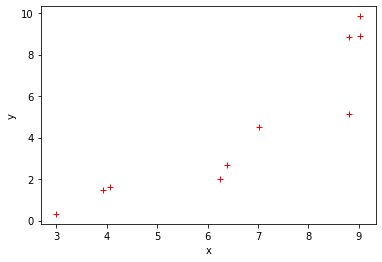

In [8]:
n = 10
np.random.seed(2019)
x = np.sort(np.random.uniform(0, 10, (1, n)))
y = np.sort(np.random.uniform(0, 10, (1, n)))

plt.plot(x, y, 'r+')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [0]:
p_x = x.shape[0] # size of input layer
p_h = 2 # size of hidden layer
p_y = y.shape[0] # size of output layer

In [10]:
nn_structure = [
  {'input_dim': p_x, 'output_dim': p_h, 'activation': 'sigmoid'},
  {'input_dim': p_h, 'output_dim': p_y, 'activation': 'linear'},
]
nn_structure

[{'activation': 'sigmoid', 'input_dim': 1, 'output_dim': 2},
 {'activation': 'linear', 'input_dim': 2, 'output_dim': 1}]

In [0]:
loss_function = mse_loss()

In [12]:
parameters = init_layers(nn_structure)
parameters

{'W1': array([[-0.0217679 ],
        [ 0.08214554]]),
 'W2': array([[0.14812778, 0.1331864 ]]),
 'b1': array([[0.],
        [0.]]),
 'b2': array([[0.]])}

Epoch 0, Loss 30.3830


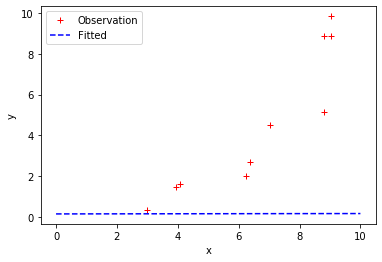

Epoch 500, Loss 3.9324


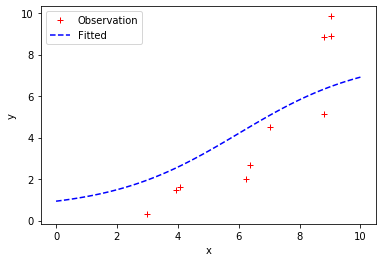

Epoch 1000, Loss 2.6092


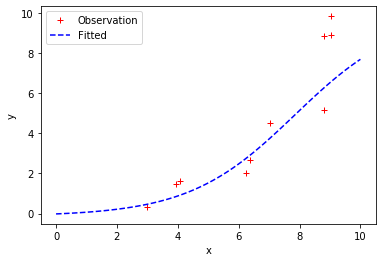

Epoch 1500, Loss 1.9341


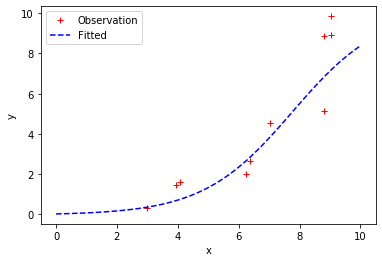

Epoch 2000, Loss 1.7097


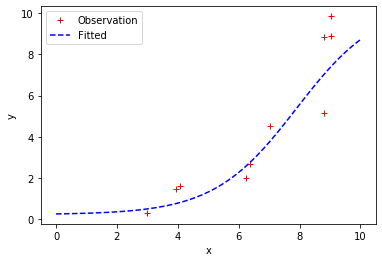

Epoch 2500, Loss 1.5619


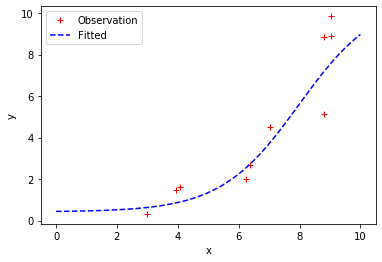

Epoch 3000, Loss 1.4726


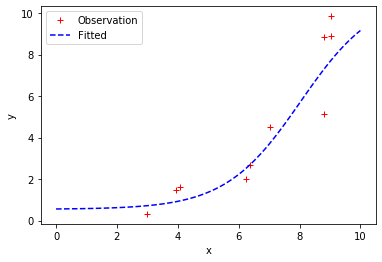

Epoch 3500, Loss 1.4177


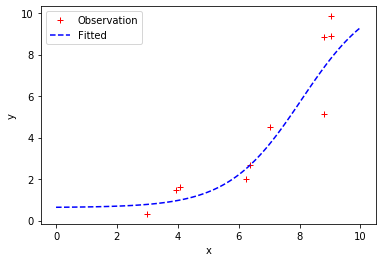

Epoch 4000, Loss 1.3823


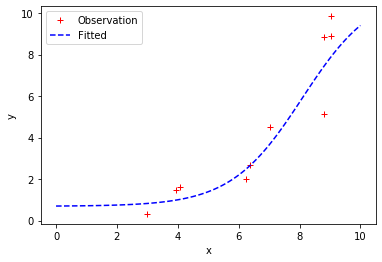

Epoch 4500, Loss 1.3584


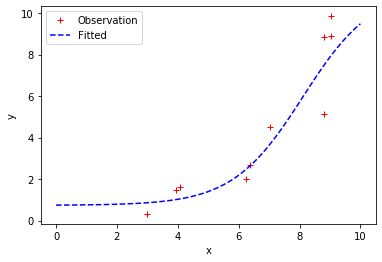

Epoch 5000, Loss 1.3418


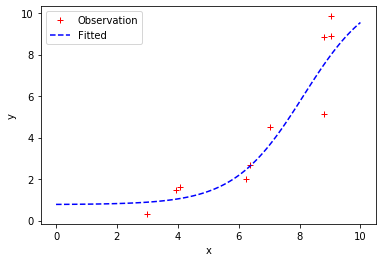

In [13]:
x_array = np.linspace(0, 10, 101).reshape(1, -1)

lr = 1e-1
history = []
for e in range(5001):
  y_hat, memory = full_forward_propagation(x, parameters, nn_structure)
  loss = loss_function.loss(y_hat, y)
  history.append(loss)

  if e % 500 == 0:
    print('Epoch ' + str(e) + ', Loss ' + f'{loss.squeeze():.4f}')
    plt.plot(x[0], y[0], 'r+', label='Observation')
    plt.xlabel('x')
    plt.ylabel('y')
    fitted, _ = full_forward_propagation(x_array, parameters, nn_structure)
    plt.plot(x_array[0], fitted[0], 'b--', label='Fitted')
    plt.legend()
    plt.show()

  gradients = full_backward_propagation(y_hat, y, memory, parameters, nn_structure, loss_function)
  parameters = update(parameters, gradients, nn_structure, lr)

# Classification Example

#### Make synthetic points

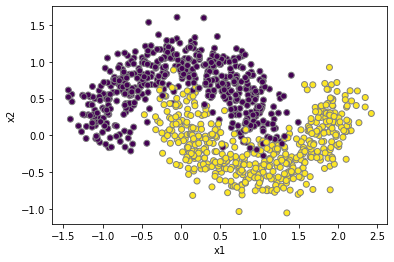

In [14]:
n = 1000
x0, y0 = make_moons(n_samples=n, noise=0.2, random_state=2019)

plt.scatter(x0[:,0], x0[:,1], c=y0.ravel(), edgecolors='grey')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [0]:
x = x0.T
y = y0.reshape(-1, n)

In [0]:
p_x = x.shape[0] # size of input layer
p_h = 4 # size of hidden layer
p_y = y.shape[0] # size of output layer

In [17]:
nn_structure = [
  {'input_dim': p_x, 'output_dim': p_h, 'activation': 'relu'},
  {'input_dim': p_h, 'output_dim': p_h, 'activation': 'relu'},
  {'input_dim': p_h, 'output_dim': p_h, 'activation': 'relu'},
  {'input_dim': p_h, 'output_dim': p_y, 'activation': 'sigmoid'},
]
nn_structure

[{'activation': 'relu', 'input_dim': 2, 'output_dim': 4},
 {'activation': 'relu', 'input_dim': 4, 'output_dim': 4},
 {'activation': 'relu', 'input_dim': 4, 'output_dim': 4},
 {'activation': 'sigmoid', 'input_dim': 4, 'output_dim': 1}]

In [0]:
loss_function = crossentropy_loss()

In [0]:
parameters = init_layers(nn_structure)

Epoch 0, Loss 693.0954


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.


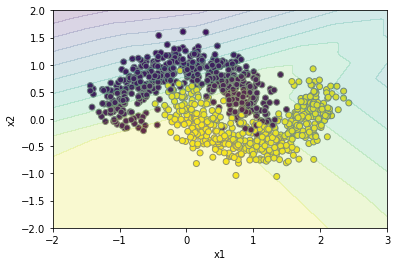

Epoch 1000, Loss 104.4507


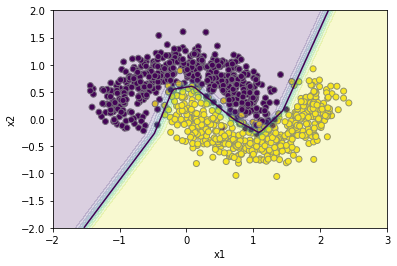

Epoch 2000, Loss 97.2464


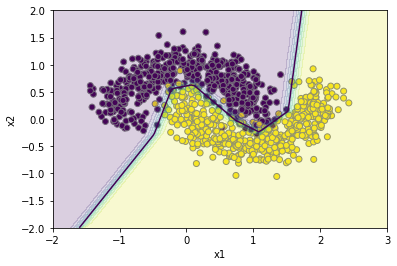

Epoch 3000, Loss 95.2967


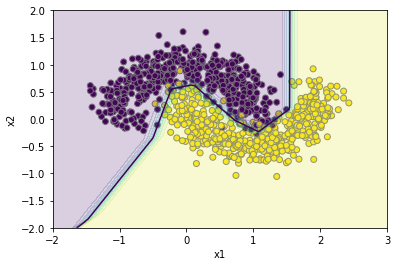

Epoch 4000, Loss 92.8610


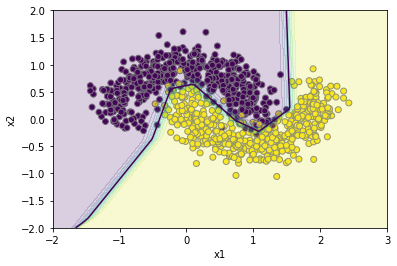

Epoch 5000, Loss 93.1138


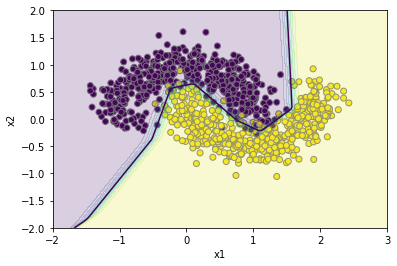

Epoch 6000, Loss 93.2751


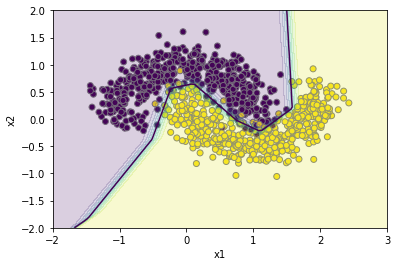

Epoch 7000, Loss 94.5620


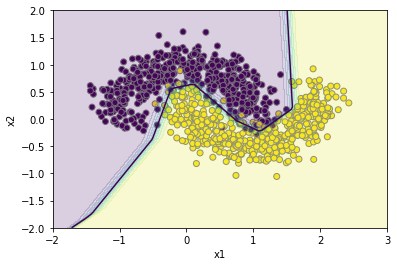

Epoch 8000, Loss 93.9725


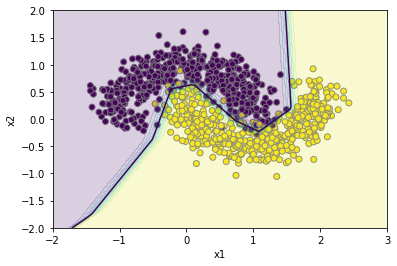

Epoch 9000, Loss 96.4883


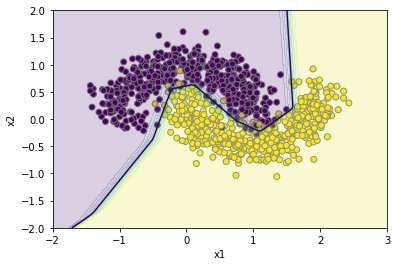

Epoch 10000, Loss 95.4138


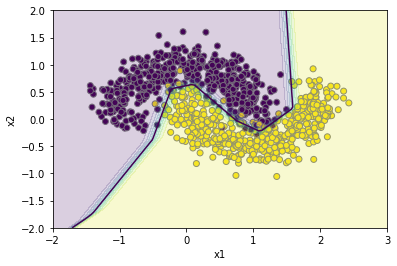

In [20]:
grid = np.mgrid[-2:3:100j, -2:2:100j]
grid_2d = grid.reshape(2, -1)
x1_array, x2_array = grid

lr = 1e0
history = []
for e in range(10001):
  y_hat, memory = full_forward_propagation(x, parameters, nn_structure)
  loss = loss_function.loss(y_hat, y)
  history.append(loss)

  if e % 1000 == 0:
    print('Epoch ' + str(e) + ', Loss ' + f'{loss.squeeze():.4f}')
    plt.scatter(x0[:,0], x0[:,1], c=y0.ravel(), edgecolors='grey')
    plt.xlabel('x1')
    plt.ylabel('x2')
    fitted, _ = full_forward_propagation(grid_2d, parameters, nn_structure)
    plt.contourf(x1_array, x2_array, fitted.reshape(x1_array.shape), 11, alpha=.2)
    plt.contour(x1_array, x2_array, fitted.reshape(x1_array.shape), levels=[.5])
    plt.show()

  gradients = full_backward_propagation(y_hat, y, memory, parameters, nn_structure, loss_function)
  parameters = update(parameters, gradients, nn_structure, lr)